<a href="https://colab.research.google.com/github/lazy-wolf/python-class-notes/blob/main/A2_Kaggle_Dataset_Model_Comparisons_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 2**

```
# Authoured by: Wasim Dawood Shaik
# UNB ID: 3744476
# Date: 23-10-2023
```

**Delivarable_1 : Create your own separate python notebooks in Colab for each of the three sources.**

**Creating separate python notebooks in Colab for using pre-trained models and dataset from Kaggle**

**Import Libraries**

In [1]:
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Dataset Info**

[mango leaf disease dataset link](https://huggingface.co/datasets/beans)

*https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset/data*

**Importing Dataset from Kaggle Datasets from Google Drive**

**Data Preprocessing and Data Analysis**

In [3]:
directory = "/content/drive/MyDrive/TME_6015/Assignment_2/Mango_Leaf_Disease"
batch_size = 32
img_height = 128
img_width = 128
train_data = tf.keras.utils.image_dataset_from_directory(directory,
                                                         validation_split=0.2,
                                                         seed=123,
                                                         subset="training",
                                                         image_size=(img_height, img_width),
                                                         batch_size=batch_size)

Found 4000 files belonging to 8 classes.
Using 3200 files for training.


In [4]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
class_names =train_data.class_names
print(class_names)

['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [6]:
val_data = tf.keras.utils.image_dataset_from_directory(directory,
                                                       validation_split=0.2,
                                                       subset="validation",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size)

Found 4000 files belonging to 8 classes.
Using 800 files for validation.


In [7]:
val_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

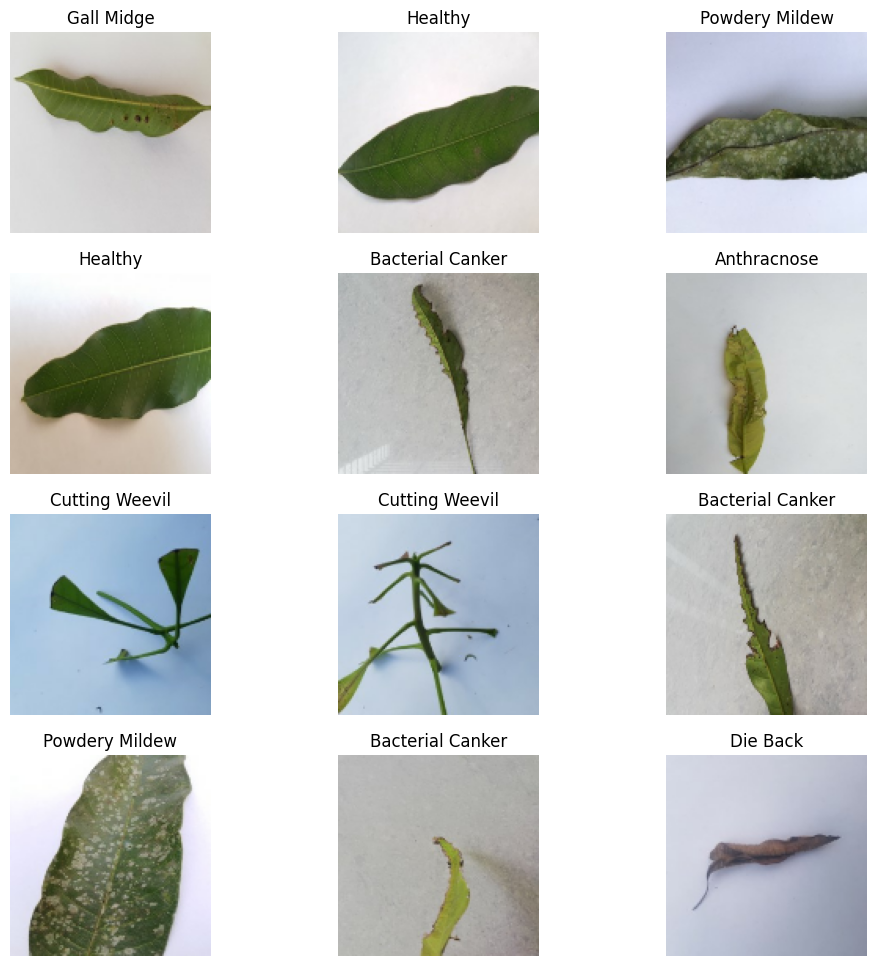

In [8]:
plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Create a Model**

[mobilenet-v2 link](https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2)

*https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2*

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [10]:
model_handle = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"

feature_extractor = hub.KerasLayer(model_handle,
                                   trainable=True)
num_class = 8
model = tf.keras.Sequential(
    [
        normalization_layer,
        feature_extractor,
        tf.keras.layers.Dense(num_class, activation="softmax")
    ]
)
model.build([None, 128, 128, 3])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 8)                 8016      
                                                                 
Total params: 1700505 (6.49 MB)
Trainable params: 1686425 (6.43 MB)
Non-trainable params: 14080 (55.00 KB)
_________________________________________________________________


**Compile and Train the Model**

In [12]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), # different loss function for multiclass classifcation
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"]
             )

In [13]:
learning_rate_reduction=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=2,factor=0.5, min_lr=0.00001,verbose =1)
Early_Stopping= tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True)

In [ ]:
history_1= model.fit(train_data, epochs=20, validation_data= val_data,callbacks=[Early_Stopping,learning_rate_reduction], verbose=1)

Epoch 1/20
100/100 [==============================] - 665s 6s/step - loss: 0.8148 - accuracy: 0.8684 - val_loss: 5.7837 - val_accuracy: 0.6162 - lr: 0.0010
Epoch 2/20
 23/100 [=====>........................] - ETA: 1:17 - loss: 0.3346 - accuracy: 0.9484

**Evaluate the Model**

In [ ]:
loss, accuracy= model.evaluate(val_data)
print(f"loss is: {loss}")
print(f"accuacy is: {accuracy}")

In [ ]:
history_mobilenet_v2= pd.DataFrame(history_1.history)
history_mobilenet_v2.head()

**Plot Training History**

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history_mobilenet_v2['loss'],label='Train_Loss')
plt.plot(history_mobilenet_v2['val_loss'],label='Validation_Loss')
plt.title('Train_Loss and Validation_Loss',fontsize=15)
plt.legend()


plt.subplot(1,2,2)
plt.plot(history_mobilenet_v2['accuracy'],label='Train_Accuracy')
plt.plot(history_mobilenet_v2['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy and Validation_Accuracy',fontsize=15)
plt.legend()
plt.show()

**Model Accuracy**

In [ ]:
x_test=[]
y_test=[]
y_pred=[]

for images, labels in val_data:
    x_test.extend(images.numpy())
    y_test.extend(labels.numpy())


predictions=model.predict(np.array(x_test))
for i in predictions:
    y_pred.append(np.argmax(i))

**Accuracy Score of Model on Test Dataset**

In [ ]:
model_1_accuracy = accuracy_score(y_test, y_pred)*100
accuracy_score(y_test, y_pred)*100

**Delivarable_2 : Show a few examples of the predicted output**

**Showing Examples of Predicted Output**

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(x_test[i].astype("uint8"))
    actual_label = class_names[y_test[i]]
    predicted_label = class_names[y_pred[i]]

    # Check if the actual and predicted labels are the same
    if actual_label == predicted_label:
        label_color = 'green'
    else:
        label_color = 'red'

    plt.title(f'Actual: {actual_label} \n Predicted: {predicted_label}', color=label_color)
    plt.axis("off")

plt.show()

**F-1, Precision, Recall Scores - Macro**

In [ ]:

f1_score_value = f1_score(y_pred, y_test, average="macro")
precision_score_value = precision_score(y_pred, y_test, average="macro")
recall_score_value = recall_score(y_pred, y_test, average="macro")

# Print the Results
print(f"F1-Score:{f1_score_value}")
print(f"Precision:{precision_score_value}")
print(f"Recall:{recall_score_value}")

In [ ]:
y_test_labels=list(map(lambda e: class_names[e], y_test))

In [ ]:
y_test_labels[:5]

In [ ]:
y_pred_labels=list(map(lambda e: class_names[e], y_pred))

In [ ]:
y_pred_labels[:5]

**Classification Report**


In [ ]:
print("Classification_Report")
print("-----------------------")
print(classification_report(y_test_labels,y_pred_labels))

**Delivarable_3 : Display the results of the prediction results using a confusion matrix**

**Displaying Prediction Results using Confusion Matrix**

In [ ]:
print("Confusion_Matrix")
print("----------------------")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names, xticks_rotation="vertical")
plt.show()

**Deliverable_4 : Choose one of the above examples (i.e. Tensorflow or Huggingface or Kaggle) and implement a 2 different models on the same test set**

**Model - 2**

**Data Preprocessing and Data Analysis**

In [ ]:
directory = "/content/drive/MyDrive/TME_6015/Assignment_2/Mango_Leaf_Disease"
batch_size = 32
img_height = 128
img_width = 128
train_data = tf.keras.utils.image_dataset_from_directory(directory,
                                                         validation_split=0.2,
                                                         seed=123,
                                                         subset="training",
                                                         image_size=(img_height, img_width),
                                                         batch_size=batch_size)

In [ ]:
train_data

In [ ]:
class_names =train_data.class_names
print(class_names)

In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(directory,
                                                       validation_split=0.2,
                                                       subset="validation",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size)

In [ ]:
val_data

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Create a Model**

[mobilenet-v1 link](https://www.kaggle.com/models/google/mobilenet-v1/frameworks/TensorFlow2/variations/025-128-classification/versions/2)

*https://www.kaggle.com/models/google/mobilenet-v1/frameworks/TensorFlow2/variations/025-128-classification/versions/2*

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
model_handle = "https://www.kaggle.com/models/google/mobilenet-v1/frameworks/TensorFlow2/variations/025-128-classification/versions/2"

feature_extractor = hub.KerasLayer(model_handle,
                                   trainable=True)
num_class = 8
model = tf.keras.Sequential(
    [
        normalization_layer,
        feature_extractor,
        tf.keras.layers.Dense(num_class, activation="softmax")
    ]
)
model.build([None, 128, 128, 3])

In [ ]:
model.summary()

**Compile and Train the Model**

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), # different loss function for multiclass classifcation
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"]
             )

In [ ]:
learning_rate_reduction=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=2,factor=0.5, min_lr=0.00001,verbose =1)
Early_Stopping= tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True)

In [ ]:
history_2= model.fit(train_data, epochs=20, validation_data= val_data,callbacks=[Early_Stopping,learning_rate_reduction], verbose=1)

**Evaluate the Model**

In [ ]:
loss, accuracy= model.evaluate(val_data)
print(f"loss is: {loss}")
print(f"accuacy is: {accuracy}")

In [ ]:
history_mobilenet_v1= pd.DataFrame(history_2.history)
history_mobilenet_v1.head()

**Plot Training History**

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history_mobilenet_v1['loss'],label='Train_Loss')
plt.plot(history_mobilenet_v1['val_loss'],label='Validation_Loss')
plt.title('Train_Loss and Validation_Loss',fontsize=15)
plt.legend()


plt.subplot(1,2,2)
plt.plot(history_mobilenet_v1['accuracy'],label='Train_Accuracy')
plt.plot(history_mobilenet_v1['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy and Validation_Accuracy',fontsize=15)
plt.legend()
plt.show()

**Model Accuracy**

In [ ]:
x_test=[]
y_test=[]
y_pred=[]

for images, labels in val_data:
    x_test.extend(images.numpy())
    y_test.extend(labels.numpy())


predictions=model.predict(np.array(x_test))
for i in predictions:
    y_pred.append(np.argmax(i))

**Accuracy Score of Model on Test Dataset**

In [ ]:
model_2_accuracy = accuracy_score(y_test, y_pred)*100
accuracy_score(y_test, y_pred)*100

**Delivarable_2 : Show a few examples of the predicted output**

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(x_test[i].astype("uint8"))
    actual_label = class_names[y_test[i]]
    predicted_label = class_names[y_pred[i]]

    # Check if the actual and predicted labels are the same
    if actual_label == predicted_label:
        label_color = 'green'
    else:
        label_color = 'red'

    plt.title(f'Actual: {actual_label} \n Predicted: {predicted_label}', color=label_color)
    plt.axis("off")

plt.show()

**F-1, Precision, Recall Scores - Macro**

In [ ]:

f1_score_value = f1_score(y_pred, y_test, average="macro")
precision_score_value = precision_score(y_pred, y_test, average="macro")
recall_score_value = recall_score(y_pred, y_test, average="macro")

# Print the Results
print(f"F1-Score:{f1_score_value}")
print(f"Precision:{precision_score_value}")
print(f"Recall:{recall_score_value}")

In [ ]:
y_test_labels=list(map(lambda e: class_names[e], y_test))

In [ ]:
y_test_labels[:5]

In [ ]:
y_pred_labels=list(map(lambda e: class_names[e], y_pred))

In [ ]:
y_pred_labels[:5]

**Classification Report**

In [ ]:
print("Classification_Report")
print("-----------------------")
print(classification_report(y_test_labels,y_pred_labels))

**Delivarable_3 : Display the results of the prediction results using a confusion matrix**

**Displaying Prediction Results using Confusion Matrix**

In [ ]:
print("Confusion_Matrix")
print("----------------------")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names, xticks_rotation="vertical")
plt.show()

**Deliverable_5 : Compare the results between the models**

**Comparing Results between two Models - MobileNet V1 vs V2**

In [ ]:
print(f"Model - 1 : Mobile V2 Accuracy score : {model_1_accuracy}")
print(f"Model - 2 : Mobile V1 Accuracy score : {model_2_accuracy}")